In [80]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, SampleSet2D
from multiple_chains import MultipleChains
from tqdm import tqdm

In [81]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .90

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

# n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [82]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 2.03 and 5.97
The Credible Interval for y is between 0.52 and 3.48


In [83]:
# CHOLESKY SAMPLING

# samples_ch = SampleSet(n.cholesky_sample(20000))
# samples_ch.samples_plot(.95, kind='hist')

In [84]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 5
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 10

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

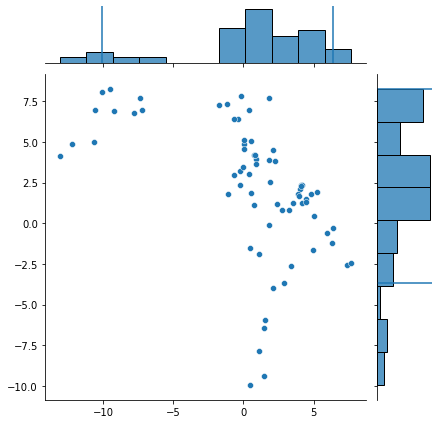

In [85]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

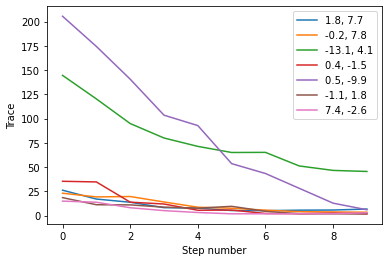

In [86]:
mh.traces_plot(every=1)

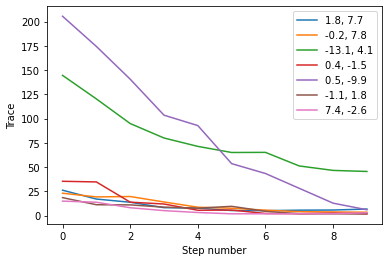

In [87]:
# mh.trim_chains(mh.optimal_trimming)

mh.traces_plot(every=1)

In [88]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[  9.21269834 -22.2169508 ]
 [-22.2169508    5.74854701]]
[1.133602553082068, 1.202796032161019, 1.1617387288135204, 1.165582506945287, 1.2072130268846022, 1.1805616273318802, 1.1703480406346576]


In [89]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [90]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)
# g.trim_chains(g.optimal_trimming)

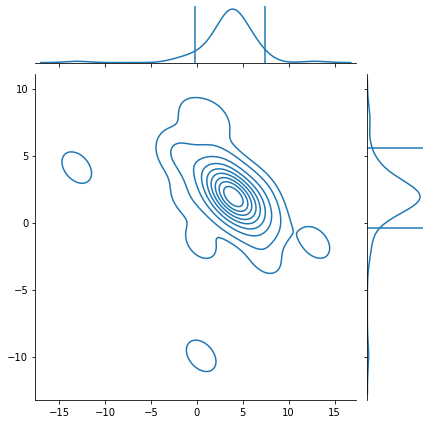

In [91]:
# g.traces_plot()
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [92]:
errors_mh_mean = []
errors_mh_cov = []
errors_g_mean = []
errors_g_cov = []

N = np.geomspace(chain_length, int(2e5), dtype=int, num=200)
diffs = np.ediff1d(N, to_end=0) # discrete gradient of N
trimming_index = 50

for i, diff in tqdm(enumerate(diffs)):
    errors_mh_mean.append(np.average(np.sqrt((mh.average_mean - n.mean)**2)))
    errors_mh_cov.append(np.average(np.sqrt((mh.average_covariance - n.cov)**2)))
    errors_g_mean.append(np.average(np.sqrt((g.average_mean - n.mean)**2)))
    errors_g_cov.append(np.average(np.sqrt((g.average_covariance - n.cov)**2)))

    if i == trimming_index:
        g.trim_chains(g.optimal_trimming)
        mh.trim_chains(mh.optimal_trimming)

    g.extend_chains(diff)
    mh.extend_chains(diff)

50it [00:08,  4.61it/s]threshold is too low!
threshold is too low!
threshold is too low!
threshold is too low!
threshold is too high!
threshold is too low!
200it [10:06,  3.03s/it]


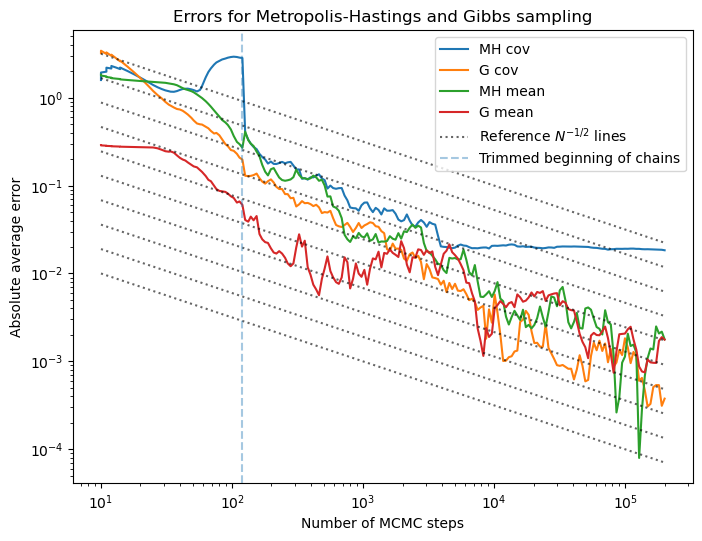

In [95]:
plt.figure(dpi=100, figsize=(8, 6))
plt.loglog(N, errors_mh_cov, label = 'MH cov')
plt.loglog(N, errors_g_cov, label = 'G cov')
plt.loglog(N, errors_mh_mean, label = 'MH mean')
plt.loglog(N, errors_g_mean, label = 'G mean')

leg = 'Reference $N^{-1/2}$ lines'
for C in np.logspace(1, -1.5, num=10):
    plt.plot(N, N**(-1/2) * C, ls=':', c='black', alpha=.6, label=leg)
    leg=None

plt.axvline(N[trimming_index], ls='--', alpha = .4, label='Trimmed beginning of chains')

plt.legend()
plt.title('Errors for Metropolis-Hastings and Gibbs sampling')
plt.xlabel('Number of MCMC steps')
plt.ylabel('Absolute average error')
plt.savefig('error_scaling_5.pdf')